<a href="https://colab.research.google.com/github/mehkzhra/Plant-disease-prediction/blob/main/PLANT_DISEASE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()  # <-- upload kaggle.json here

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Example dataset: PlantVillage (best for leaf disease classification)
!kaggle datasets download -d emmarex/plantdisease

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 99% 654M/658M [00:01<00:00, 288MB/s]
100% 658M/658M [00:01<00:00, 381MB/s]


In [ ]:
!unzip -q /content/plantdisease.zip -d /content/plantvillage


In [ ]:
!ls /content


kaggle.json  plantdisease.zip  plantvillage  sample_data


In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image


In [ ]:
data_dir = '/content/plantvillage/PlantVillage'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

classes = dataset.classes
len(classes)


15

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18
model = models.resnet18(weights="IMAGENET1K_V1")

# Replace final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
epochs = 3  # keep small for 10–15 min training

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/3, Loss: 0.2556
Epoch 2/3, Loss: 0.1002
Epoch 3/3, Loss: 0.0625


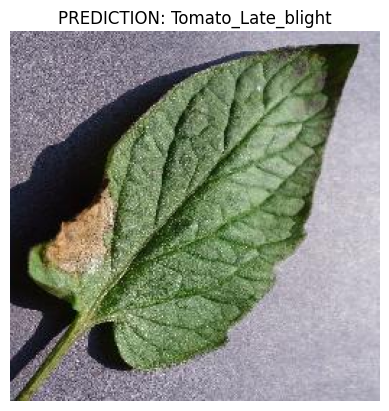

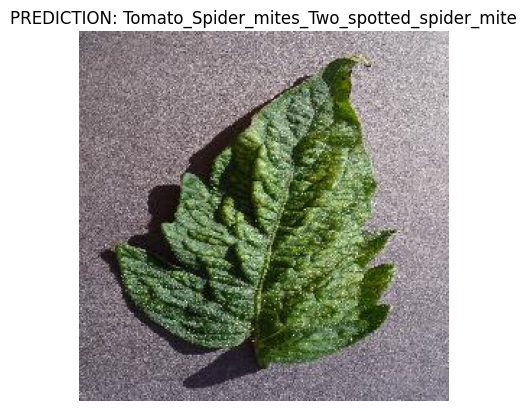

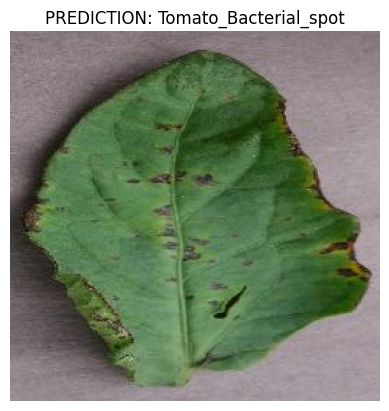

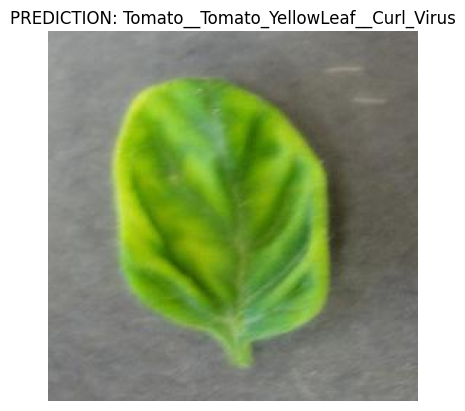

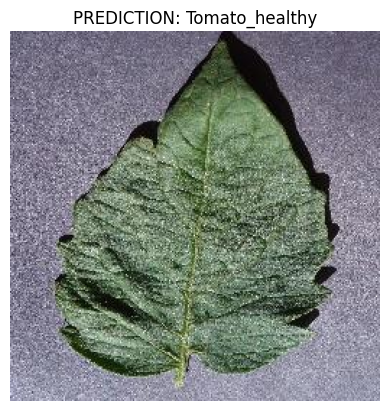

In [ ]:
import random

model.eval()

test_images = random.sample(dataset.samples, 5)

for path, _ in test_images:
    img = Image.open(path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)

    output = model(img_t)
    _, pred = torch.max(output, 1)

    predicted_class = classes[pred.item()]

    plt.imshow(img)
    plt.title(f"PREDICTION: {predicted_class}")
    plt.axis('off')
    plt.show()
